
# Trabalho 2

## Grupo 24

### Pedro Faria - A72640
### Hugo Costeira - A87976


## 1. 
Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . 

O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n​_1​​, n_2 \rangle$​  tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
    
    
### a. 
Gerar aleatoriamente um tal grafo com  $N=32$ nodos.  Cada nodo tem um número aleatório de descendentes no intervalo $\,1..3\,$  cujos destinos são distintos entre si do nodo origem.

In [1]:
!pip install ortools

In [1]:
import networkx as nx
import random
from ortools.linear_solver import pywraplp

## 1.a 
### Geração de um Grafo

Para Gerar um grafo $G$ com as restrições pedidas, primeiramente criaremos uma lista com 32 entradas que representam os nossos vértices, $V$ , com variação de 1 a 3, que representará a nossa lista de arestas,$(E)$.

Após esse passo verificaremos usando o algoritmo de Erdos Gallai se a lista de vertices é realizavel num grafo simples. Depois verificaremos se o grafo gerado é ligado, se assim for transforma-lo-emos num grafo orientado, usando a função $nx.to\_directed()$ que para cada aresta $(u,v)$ irá criar uma aresta $(v,u)$.

Por fim verificamos se o grafo é fortemente ligado, ie, qualquer vértice é acessivel de qualquer outro ( $\forall n,s \in V$ existe um caminho $: n \rightarrow s \lor s\rightarrow n$ )

DiGraph with 32 nodes and 74 edges


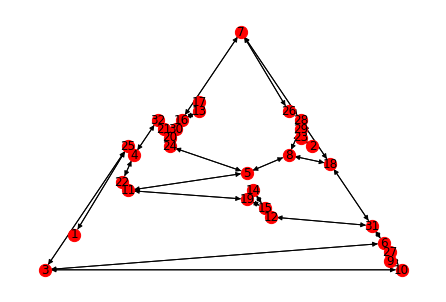

In [8]:
def gera(n):
    lista=[]
    flag = 0
    while (flag ==0):
        lista = []
        for i in range(1,n+1):
            lista.append(random.randint(1,3))

        if nx.is_valid_degree_sequence_erdos_gallai(lista):
            G = nx.random_degree_sequence_graph(lista)
            G = nx.convert_node_labels_to_integers(G,first_label=1)

            if (nx.is_connected(G)==True):
                H = nx.DiGraph()
                H = G.to_directed()
                if(nx.is_strongly_connected(H)==True):
                  flag = 1
                  return H

n =32
G=gera(n)
pos = nx.planar_layout(G)
print(G)
nx.draw(G,pos, with_labels = True,node_size=150,node_color='red')

## 1.b 
Determinar o maior número de vias que é possível remover mantendo o grafo ligado

Teremos de gerar um subgrafo $H$ de $G$ que tera o menor numero de arestas possiveis de $G$, mantendo a condição de incluir todos os vertices

Para tal utilizaremos o solver $CP-SAT$ com as seguintes restrições:

**Restrições**

Seja $E$ o conjunto de todas as arestas de $G$ e $C_{s,t}$ o conjunto de todos os caminhos simples entre $s$ e $t$

### 1. 
Para todos o caminhos de $G$ , se um dado caminho $c$ de origem no nodo $e_s$ e destino $e_t$ está presente no subgrafo, então todas a arestas desse caminho terão de existir no subgrafo:

$$\forall_{e<E} \cdot \forall_{c<C} \cdot \forall_{e'<c} ( d_{e'} \, \geq x_{e}) $$

Para $e'$ o conjunto todas as arestas de $c$

### 2. 
Para todas as arestas  $e\in E$ existe pelo menos um caminho de origem $e_s$ e destino $e_t$:

$$\forall_{e<E} \, \sum_{c<C}\, x_e \geq 1$$


DiGraph with 32 nodes and 34 edges


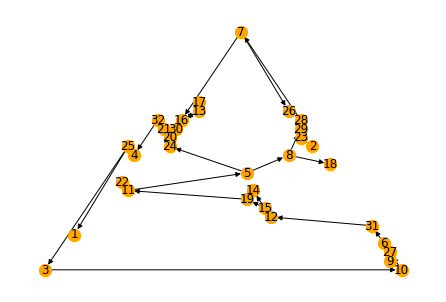

In [9]:
def arestas(p): 
    return [(p[i],p[i+1]) for i in range(1,len(p)-1)]

def geraSub(graph): 
    sol = pywraplp.Solver.CreateSolver('CP-SAT')
    d = {}
    x = {} 
    for e in graph.edges(): # variável por aresta
        d[e] = sol.BoolVar(str(e))
    

    for s in graph.nodes:
        for t in graph.nodes:
            
            if s!=t: # evitar arestas do tipo (u,u)
              cam = list(nx.all_simple_paths(graph,s,t)) # lista de caminhos possíveis
              
              for i in range(len(cam)):#adicionar variaveis
                x[i] = sol.BoolVar(str(i) + ',' + str(s)+ ',' + str(t))

                for e in arestas(cam[i]): #toda aresta presente no caminho s,t
                  sol.Add(d[e]>=x[i])   #restrição 1
                
              
              sol.Add(sum(x.values()) >= 1)  #restrição 2
              x = {}

     #minimizar o numero de arestas necessarias   
    sol.Minimize(sum(d.values()))
    assert(sol.Solve() == pywraplp.Solver.OPTIMAL)

    remover = [ e for e in graph.edges() if round(d[e].solution_value()) == 0] #Lista com todas as arestas a remover

    H = G.copy() #criaremos um novo grafo para preservar o original
    for (o,d) in G.edges():
      if (o,d) in remover:
        H.remove_edge(o,d) # removemos as arestas selecionadas
    if nx.is_strongly_connected(H):
      print("Grafo fortemente conectado")
    return H


H= geraSub(G)
posH = nx.planar_layout(H)
nx.draw(H,pos, with_labels = True,node_size=150,node_color='orange')
print(H)

In [10]:
print("Podem-se eliminar: "+str(G.number_of_edges()-H.number_of_edges())+" arestas")

Podem-se eliminar: 40 arestas


## Exemplos

DiGraph with 32 nodes and 72 edges


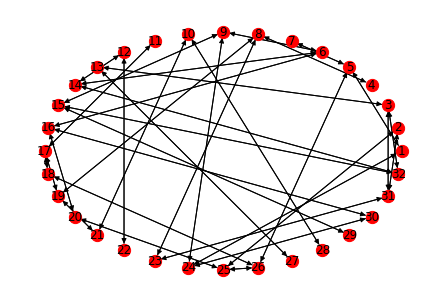

In [11]:
n =32
G=gera(n)
pos = nx.circular_layout(G)
nx.draw(G,pos, with_labels = True,node_size=150,node_color='red')
print(G)

Podem-se eliminar: 35 arestas
DiGraph with 32 nodes and 37 edges


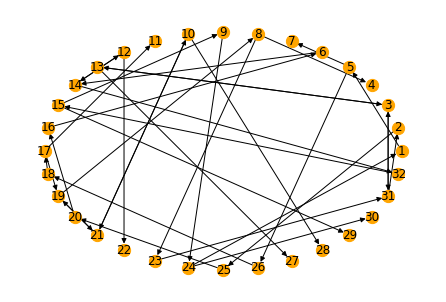

In [12]:
H= geraSub(G)
nx.draw(H,pos, with_labels = True,node_size=150,node_color='orange')
print("Podem-se eliminar: "+str(G.number_of_edges()-H.number_of_edges())+" arestas")
print(H)

DiGraph with 32 nodes and 70 edges


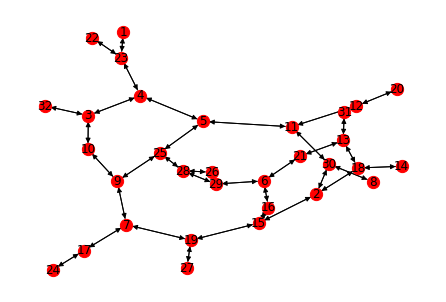

In [13]:
n =32
G=gera(n)
pos = nx.spring_layout(G)
nx.draw(G,pos, with_labels = True,node_size=150,node_color='red')
print(G)

Podem-se eliminar: 34 arestas
DiGraph with 32 nodes and 36 edges


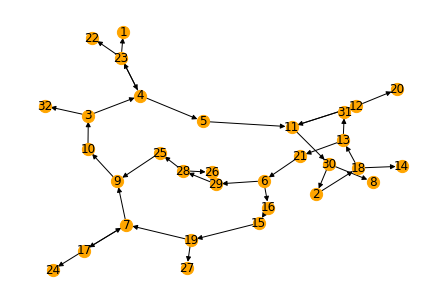

In [14]:
H= geraSub(G)
nx.draw(H,pos, with_labels = True,node_size=150,node_color='orange')
print("Podem-se eliminar: "+str(G.number_of_edges()-H.number_of_edges())+" arestas")
print(H)

DiGraph with 32 nodes and 70 edges


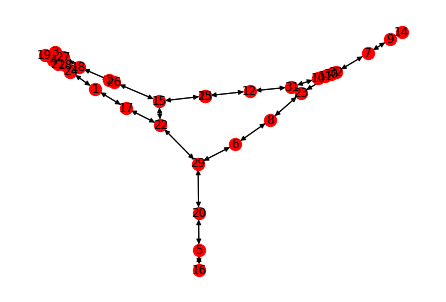

In [15]:
n =32
G=gera(n)
pos = nx.spectral_layout(G)
nx.draw(G,pos, with_labels = True,node_size=150,node_color='red')
print(G)

Podem-se eliminar: 33 arestas
DiGraph with 32 nodes and 37 edges


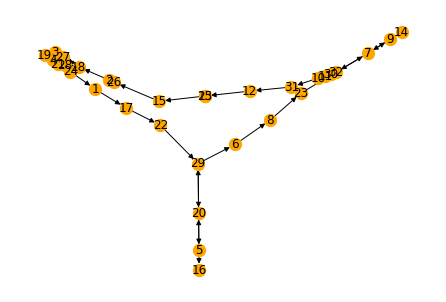

In [16]:
H= geraSub(G)
nx.draw(H,pos, with_labels = True,node_size=150,node_color='orange')
print("Podem-se eliminar: "+str(G.number_of_edges()-H.number_of_edges())+" arestas")
print(H)